# StyleGAN Latent Traversal 

In [1]:
import os
import pickle
import config
import dnnlib
import gzip
import json
import numpy as np
from tqdm import tqdm_notebook
import warnings
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
warnings.filterwarnings("ignore")

import PIL.Image
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

## Import pre-trained StyleGAN network

In [2]:
tflib.init_tf()
with open("karras2019stylegan-bedrooms-256x256.pkl", 'rb') as pickle_file:
    generator_network, discriminator_network, Gs_network = pickle.load(pickle_file)
    
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

## Sample Generation

In [3]:
qlatents = []
dlatents = []
images = []

# np.random.seed(198) # Default seed as 198 for consistency

# for i in range(100):
#     qlatent = np.random.normal(size=(1, 512))
#     dlatent = Gs_network.components.mapping.run(qlatent, None, minibatch_size=1, randomize_noise=False, structure='fixed') # untruncated by default, I guess
#     image = Gs_network.components.synthesis.run(dlatent, minibatch_size=1, randomize_noise=False, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), structure='fixed')
    
#     qlatents.append(qlatent)
#     dlatents.append(dlatent)
#     images.append(image)
    
#     #im_data = PIL.Image.fromarray(image[0], 'RGB')
#     plt.imsave("gen_bedrooms/"+str(i)+".jpg", image[0])

# print(images[0].shape)
# plt.imshow(PIL.Image.fromarray(images[0][0], 'RGB'))

dlatents = np.load("gen_bedrooms_1/dlatent_save.npy") # Load pregenerated dlatents instead

In [4]:
# np_dlatent = np.array(dlatents)
# np.save("dlatent_save.npy", np_dlatent)

## Load labels of generated samples

In [5]:
import csv

labels = []
labels_picture = []
labels_n_pillows = []
with open('gen_bedrooms_1/room_labels.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        labels.append(int(row[1]))
        labels_picture.append(int(row[2]))
        labels_n_pillows.append(int(row[3]))
    print(f'Processed {len(labels)} lines.')

Processed 100 lines.


In [6]:
X_data = []
for dlatent in dlatents:
    X_data.append(dlatent.reshape((-1, 14*512))[0])

## Imports and Utilities

In [15]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

import imageio

In [8]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 14, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector = (latent_vector + coeff*direction)
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    
def move_and_save(latent_vector, direction, coeffs, filename):
    images = []
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector = (latent_vector + coeff*direction)
        image = generate_image(new_latent_vector)
        images.append(image)
        
    imageio.mimsave('res/' + filename, images)
        

## Room Rotation Vector

In [9]:
Y_rotation_direction = np.array(labels)
assert(len(X_data) == len(Y_rotation_direction))

clf = LogisticRegression(class_weight='balanced')

scores = cross_val_score(clf, X_data, Y_rotation_direction, scoring='accuracy', cv=5)
print(scores)
print('Mean: ', np.mean(scores))

clf.fit(X_data, Y_rotation_direction)
rotation_direction = clf.coef_.reshape((14, 512))

[0.66666667 0.8        0.7        0.6        0.52631579]
Mean:  0.6585964912280702


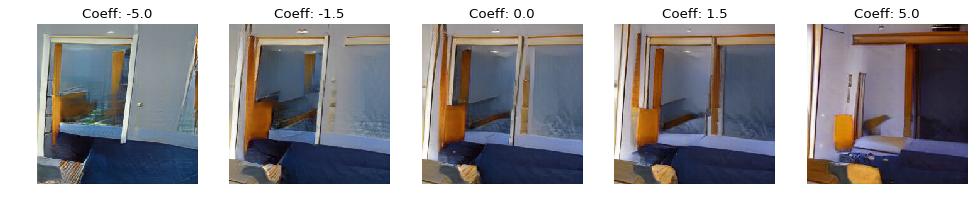

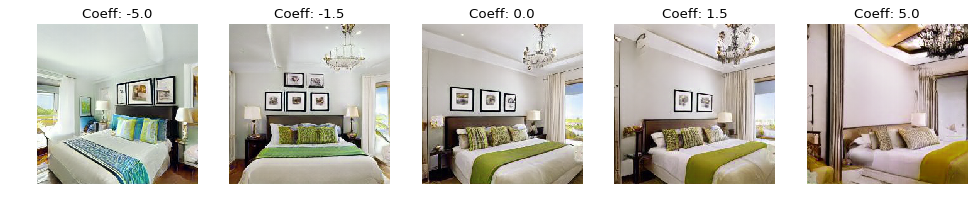

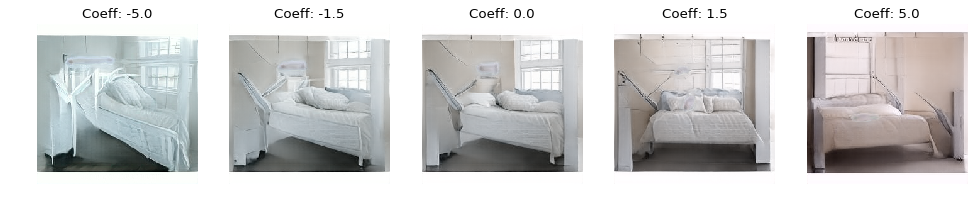

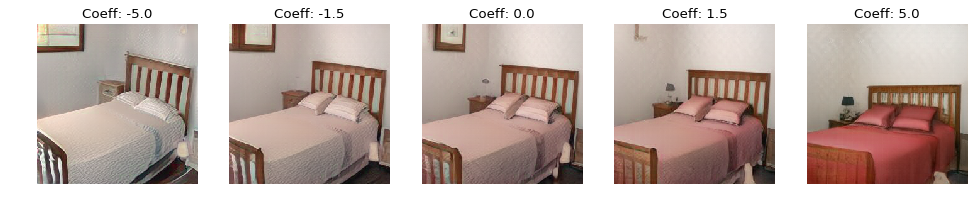

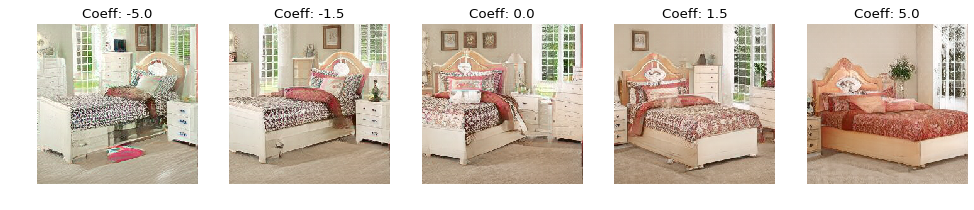

In [10]:
for i in range(5):
    move_and_show(X_data[i].reshape((-1, 14, 512)), rotation_direction, [-5, -1.5, 0, 1.5, 5])
    move_and_save(X_data[i].reshape((-1, 14, 512)), rotation_direction, np.linspace(-7, 7), str(i) + ".gif")

In [11]:
Y_picture_direction = np.array(labels_picture)
print(Y_picture_direction)

clf_picture = LogisticRegression(class_weight='balanced')

scores_picture = cross_val_score(clf, X_data, Y_picture_direction, scoring='accuracy', cv=5)
print(scores_picture)
print('Mean: ', np.mean(scores_picture))

clf_picture.fit(X_data, Y_picture_direction)
picture_direction = clf_picture.coef_.reshape((14, 512))

[0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0
 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0]
[0.57142857 0.38095238 0.55       0.47368421 0.47368421]
Mean:  0.48994987468671675


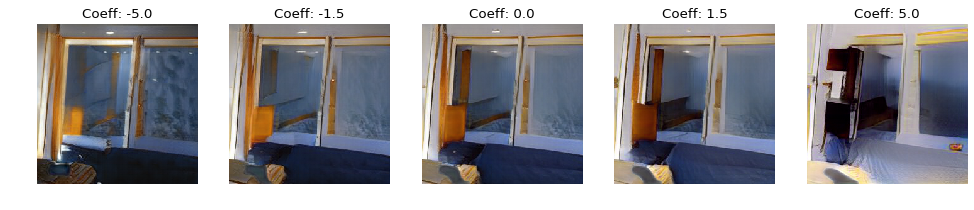

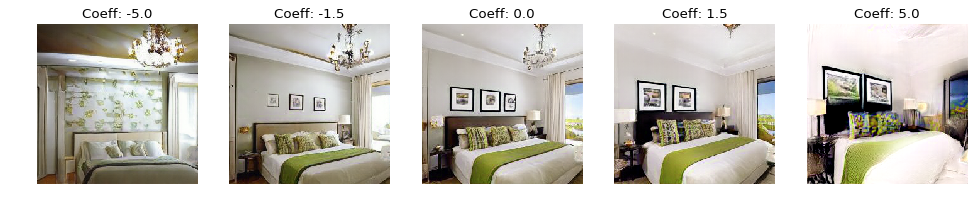

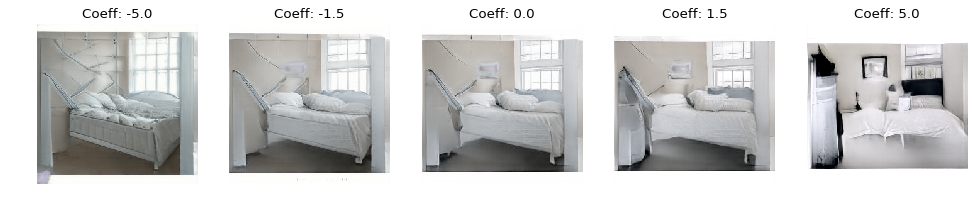

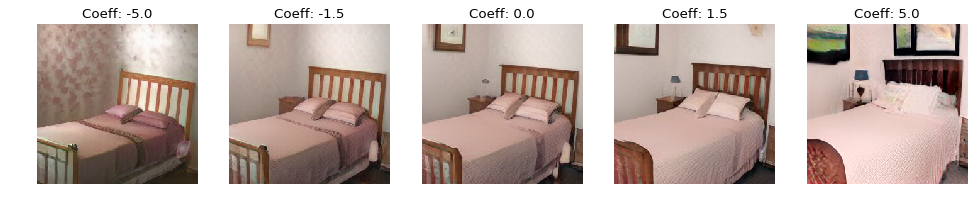

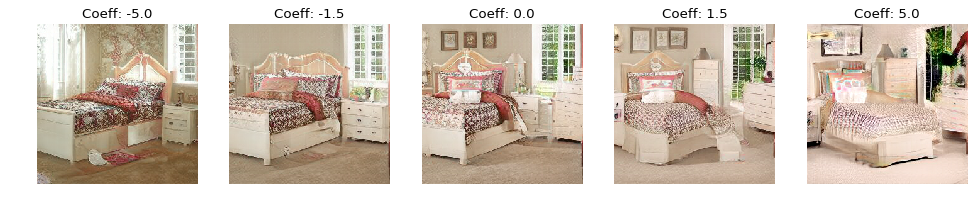

In [12]:
for i in range(5):
    move_and_show(X_data[i].reshape((-1, 14, 512)), picture_direction, [-5, -1.5, 0, 1.5, 5])
    move_and_save(X_data[i].reshape((-1, 14, 512)), picture_direction, np.linspace(-7, 7), str(i) + "_picture.gif")

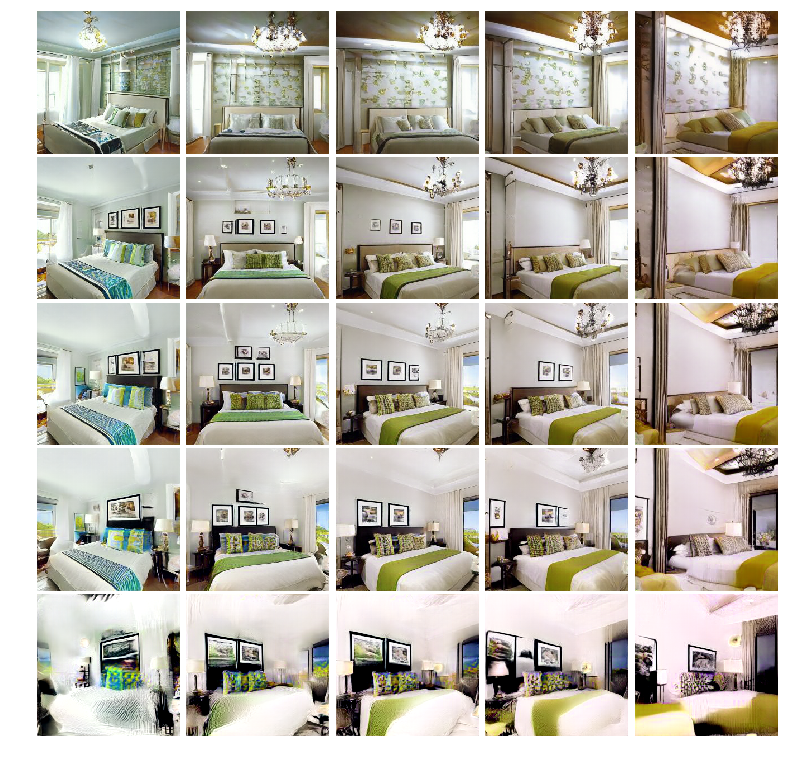

In [13]:
coeffs = [-5.0, -1.5, 0.0, 1.5, 5.0]
test_latent_vector = X_data[1].reshape((-1, 14, 512))

fig,ax = plt.subplots(5, len(coeffs), figsize=(12, 12), dpi=80, sharex = True, sharey = True, gridspec_kw = dict(wspace=0.025, hspace = 0.025))
for j , coeff_rotation in enumerate(coeffs):
    for i, coeff_picture in enumerate(coeffs):
        new_latent_vector = test_latent_vector.copy()
        new_latent_vector = (new_latent_vector + coeff_rotation*rotation_direction + coeff_picture*picture_direction)
        ax[i][j].imshow(generate_image(new_latent_vector))
        ax[i][j].axis('off')
plt.show()

In [16]:
Y_n_pillows = np.array(labels_n_pillows)
clf_pillows = LinearRegression()

clf_pillows.fit(X_data, Y_n_pillows)
pillows_direction = clf_pillows.coef_.reshape((14, 512))

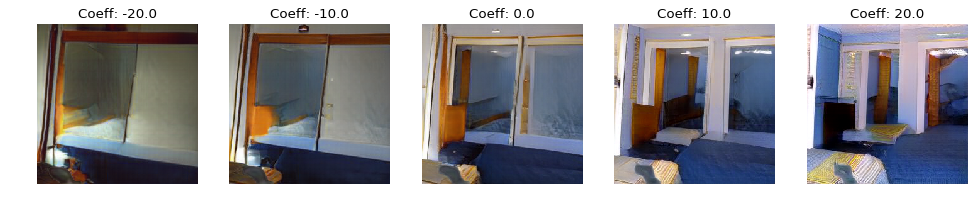

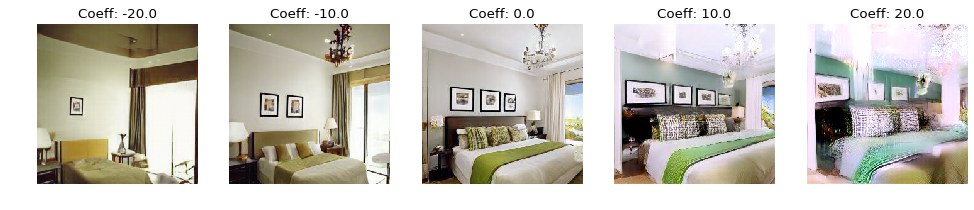

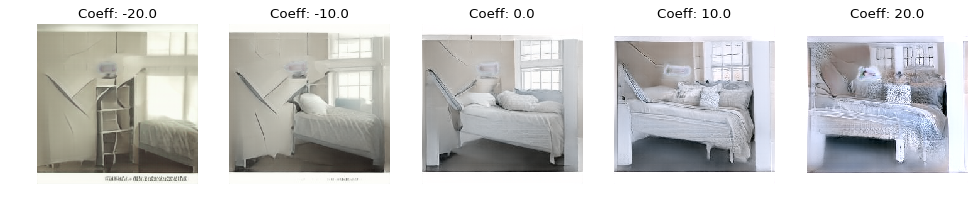

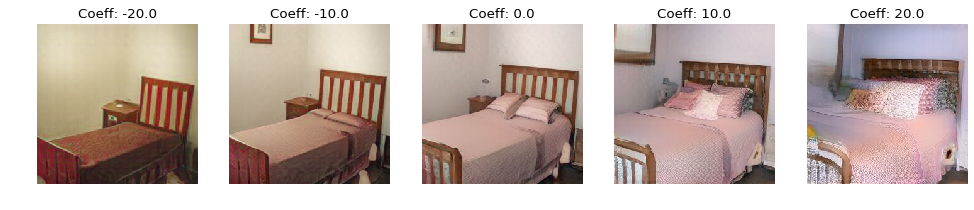

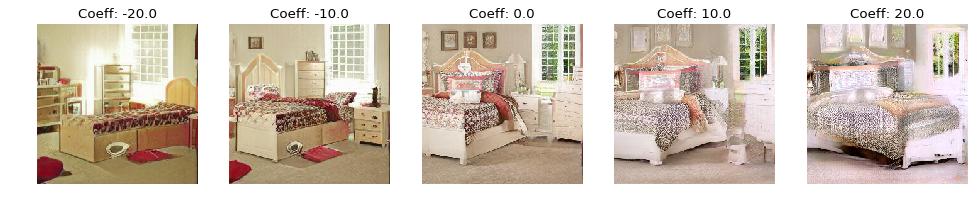

In [17]:
for i in range(5):
    move_and_show(X_data[i].reshape((-1, 14, 512)), pillows_direction, [-20, -10, 0, 10, 20])
    move_and_save(X_data[i].reshape((-1, 14, 512)), pillows_direction, np.linspace(-20, 20), str(i) + "_pillow.gif")

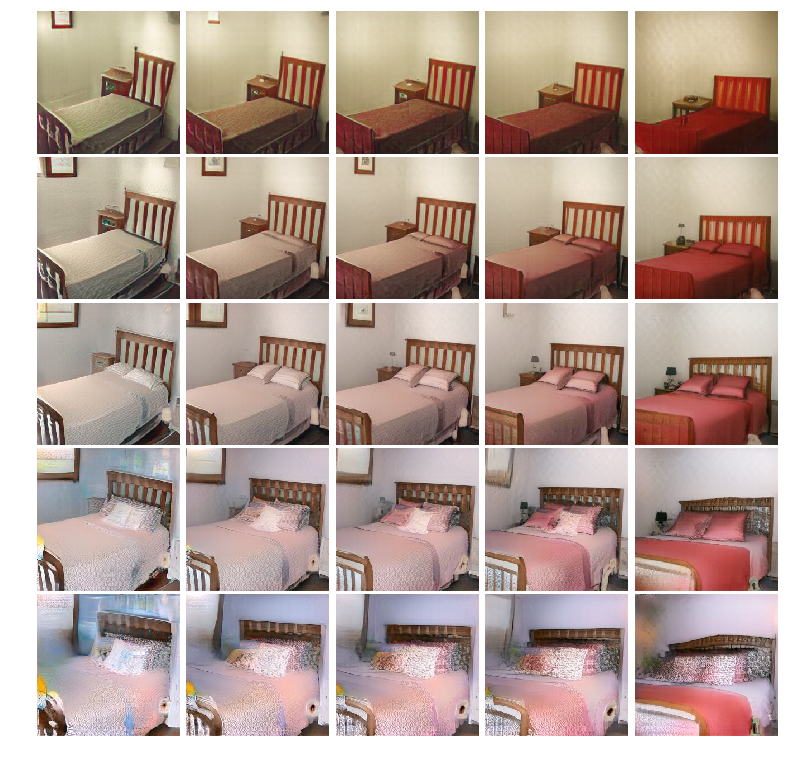

In [18]:
coeffs = [-5.0, -1.5, 0.0, 1.5, 5.0]
coeffs2 = [-20, -10, 0, 10, 20]
test_latent_vector = X_data[3].reshape((-1, 14, 512))

fig,ax = plt.subplots(5, len(coeffs), figsize=(12, 12), dpi=80, sharex = True, sharey = True, gridspec_kw = dict(wspace=0.025, hspace = 0.025))
for j , coeff_rotation in enumerate(coeffs):
    for i, coeff_picture in enumerate(coeffs2):
        new_latent_vector = test_latent_vector.copy()
        new_latent_vector = (new_latent_vector + coeff_rotation*rotation_direction + coeff_picture*pillows_direction)
        ax[i][j].imshow(generate_image(new_latent_vector))
        ax[i][j].axis('off')
plt.show()